In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import  metrics
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sb

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [ ]:
train_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/Big Mart Sale/Train.csv'
test_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/Big Mart Sale/Test.csv'
train=pd.read_csv(train_data)
test=pd.read_csv(test_data)

In [ ]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

In [ ]:
data.describe()

In [ ]:
data.head()

In [ ]:
plt.figure(figsize=(15,8))
sb.boxplot(y='Item_Weight',x='Outlet_Identifier',data=data)

In [ ]:
plt.figure(figsize=(15,8))
sb.boxplot(y='Item_Outlet_Sales',x='Item_Type', hue='Outlet_Type',data=data)

In [ ]:
plt.figure(figsize=(15,8))
sb.boxplot(y='Item_Weight',x='Outlet_Identifier', hue='Item_Fat_Content',data=data)

In [ ]:
data.isnull().sum()

In [ ]:
sb.distplot(data.Item_Weight[data.Item_Weight.isnull()==0])

In [ ]:
data.head()

In [ ]:
data.Item_Fat_Content.unique()

In [ ]:
pd.unique(data[['Outlet_Type','Outlet_Size']].values.ravel())

In [ ]:
def fat_decode(fat):
    if(fat in ('low fat','LF')):
        return 'Low Fat'
    elif(fat=='reg'):
        return 'Regular'
    else:
        return fat

In [ ]:
data.Item_Fat_Content=data.Item_Fat_Content.apply(fat_decode)

In [ ]:
data.Item_Fat_Content.unique()

In [ ]:
pd.DataFrame(data.corr()["Item_Outlet_Sales"].sort_values(ascending=False))

In [ ]:
data.loc[data.Item_Weight.isnull(),'Item_Weight']=data.Item_Weight.mean()

In [ ]:
data.loc[data.Outlet_Size.isnull()==True,'Outlet_Size']='Medium'

In [ ]:
data.head()

In [ ]:
data.Outlet_Type.unique()

In [ ]:
data['Item_Type_Der']= data.Item_Identifier.apply(lambda x: x[0:2])

In [ ]:
data['Item_Type_Der'].head()

In [ ]:
data['Item_Type_Der']=data['Item_Type_Der'].map({'FD':'Food','DR':'Drink','NC':'Non Consumable'})

In [ ]:
data['Outlet_Age']=2013-data.Outlet_Establishment_Year

In [ ]:
plt.hist(data.Item_Visibility)

In [ ]:
data=data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1)

In [ ]:
data=pd.get_dummies(data,columns=['Item_Fat_Content','Item_Type_Der','Outlet_Location_Type','Outlet_Size','Outlet_Type'])

In [2]:
data.head()

NameError: name 'data' is not defined

In [61]:
train=data[data.source=='train']
test=data[data.source=='test']
train=train.drop('source',axis=1)
test=test.drop('source',axis=1)

In [62]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
#predictors = [x for x in train.columns if x not in [target]+IDcol]
predictors=['Item_MRP','Outlet_Type_Grocery Store','Outlet_Type_Supermarket Type3','Outlet_Age','Item_Visibility','Outlet_Type_Supermarket Type1','Item_Weight','Outlet_Type_Supermarket Type2']

In [63]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[[IDcol,'predprob']], on=IDcol)
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(results[target], results['predprob']))
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [65]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBRegressor(
            nthread=4,
            n_estimators=500,
            objective='logistic',
            learning_rate=0.05,
#            num_leaves=34,
           colsample_bytree=0.75,
           subsample=0.9,
            max_depth=16,
            reg_alpha=0.35,
            reg_lambda=2,
#            min_split_gain=0.0222415,
#            min_child_weight=50,
            silent=-1,
            verbose=-1, )
modelfit(xgb1, train, test, predictors)

ValueError: could not convert string to float: 'OUT046'

In [268]:
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 100}


In [278]:
rf=RandomForestRegressor(n_estimators=100,
                                bootstrap=True,
                                max_depth=6,
                                max_features=6,
                                min_samples_split=.01,
                                min_samples_leaf=.001,
                                random_state=0)
rf.fit(x_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.001,
           min_samples_split=0.01, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [280]:
y_pred=rf.predict(x_test)

In [281]:
pd.DataFrame(y_pred).to_csv('Submission1.csv')

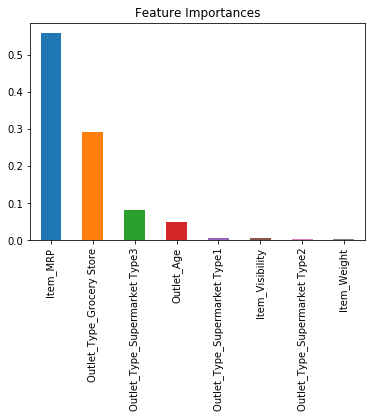

In [272]:
coef5 = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

In [273]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5681 entries, 8523 to 14203
Data columns (total 22 columns):
Item_Identifier                  5681 non-null object
Item_MRP                         5681 non-null float64
Item_Outlet_Sales                0 non-null float64
Item_Visibility                  5681 non-null float64
Item_Weight                      5681 non-null float64
Outlet_Identifier                5681 non-null object
Outlet_Age                       5681 non-null int64
Item_Fat_Content_Low Fat         5681 non-null uint8
Item_Fat_Content_Regular         5681 non-null uint8
Item_Type_Der_Drink              5681 non-null uint8
Item_Type_Der_Food               5681 non-null uint8
Item_Type_Der_Non Consumable     5681 non-null uint8
Outlet_Location_Type_Tier 1      5681 non-null uint8
Outlet_Location_Type_Tier 2      5681 non-null uint8
Outlet_Location_Type_Tier 3      5681 non-null uint8
Outlet_Size_High                 5681 non-null uint8
Outlet_Size_Medium               5